In [1]:

import torch
from flextok.flextok_wrapper import FlexTokFromHub
from diffusers.models import AutoencoderKL
from flextok.utils.demo import imgs_from_urls
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
# this model will denoise the latents given the register tokens as condition 
model = FlexTokFromHub.from_pretrained('EPFL-VILAB/flextok_d18_d28_dfn').eval().to(device)

# Load example images of shape (B, 3, 256, 256), normalized to [-1,1]
imgs = imgs_from_urls(urls=['https://storage.googleapis.com/flextok_site/nb_demo_images/2.png'])

In [48]:
# tokens_list is a list of [1, 256] discrete token sequences. These are the register tokens, which we get from the ViT.
# this tokenize method already handles the vae, where we map the images to latents.  
tokens_list = model.tokenize(imgs.to(device))

hev2


In [49]:
print(f"tokens_list shape: {len(tokens_list)} x {tokens_list[0].shape}")

tokens_list shape: 1 x torch.Size([1, 256])


In [62]:
# here, we can control the compression rate. The lesser tokens, the more compressed the image.
k_keep = 16 # For example, only keep the first 64 out of 256 tokens
tokens_list_filtered = [t[:,:k_keep] for t in tokens_list]

# tokens_list is a list of [1, l] discrete token sequences, with l <= 256
# reconst is a [B, 3, 256, 256] tensor
reconst = model.detokenize(
    tokens_list_filtered,
    timesteps=20, # Number of denoising steps
    guidance_scale=7.5, # Classifier-free guidance scale
    perform_norm_guidance=True, # See https://arxiv.org/abs/2410.02416
)

100%|██████████| 20/20 [00:03<00:00,  5.02it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0330493..1.0226077].


[tensor([[32725, 29075, 20727, 41252, 16747, 36397, 29718, 51430, 23323, 46823,
          7058, 46340, 31516, 51654, 39415, 37270]], device='cuda:0')]
torch.Size([3, 256, 256])


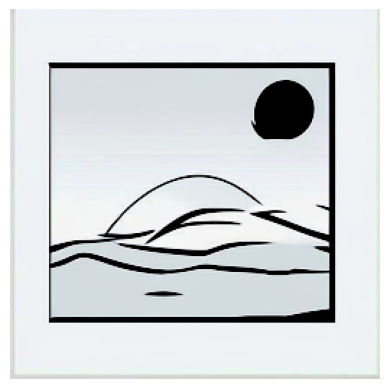

In [ ]:
# Take first (and only) image
img = reconst[0]  # → now shape [3, 256, 256]
print(img.shape)
# Rearrange from C×H×W to H×W×C for display
img = img.squeeze().permute(1, 2, 0).cpu().numpy()

plt.imshow(img)
plt.axis('off')  # hide axes
plt.show()

In [ ]:
def reconstruction_error(reconstructed_img, original_img):

    pass 

def MAE(reconstructed_img, original_img)